# Brain MRI Segmentation

This notebook contains a simplistic code for barin MRI segmentation task. 
[The dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) that is used here contains only 110 patients and is obtained from The Cancer Genome Atlas (TCGA).
Also, some parts of this code are building on top of [this notebook](https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch).

In [1]:
import os
import logging
import numpy as np
import imgaug.augmenters as iaa
%matplotlib inline

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tensorboard import notebook
%load_ext tensorboard

from datasets.brain_dataset import BrainSegmentationDataset
from datasets.transforms import Augmentation, ToTensor, ToImage
from models.unet import UNet
from metrics.dice_loss import DiceLoss, dice_score
from train import train_supervised, train_eval_supervised, train_semi_supervised, train_eval_semi_supervised
from evaluate import evaluate, generate_outputs
from utils.params import Params, save_dict_to_json
from utils.logger import set_logger, save_checkpoint, load_checkpoint
from utils.visualizer import save_image_mask, plot_samples

In [2]:
dataset_dir = "/pasteur/u/mottaghi/lgg-mri-segmentation/processed"
base_params_path = "experiments/base_params.json"
model_dir = "experiments/semi-supervised_run2"
restore = True

os.makedirs(model_dir, exist_ok=True)
params_path = os.path.join(model_dir, "params.json")
if restore and os.path.exists(params_path):
    params = Params(params_path)
else:
    params = Params(base_params_path)
    params.save(params_path)
params.model_dir = model_dir
params.restore = restore
params.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_logger(model_dir)

In [3]:
week_aug = iaa.Sequential([
    iaa.Affine(scale=(0.95, 1.05)), 
    iaa.Affine(rotate=(-15, 15)),
    iaa.Fliplr(0.5), 
])
strong_aug = iaa.Sequential([
    iaa.Affine(scale=(0.8, 1.2)), 
    iaa.Affine(rotate=(-30, 30)),
    iaa.Fliplr(0.5), 
])
week_transforms = Compose([Augmentation(week_aug), ToTensor()])
strong_transforms = Compose([Augmentation(strong_aug), ToTensor()])
params.strong_transforms = strong_transforms
totensor = ToTensor()
toimage = ToImage()

### Data

In [4]:
labeled_dataset = BrainSegmentationDataset(dataset_dir, subset="labeled", transform=week_transforms, params=params)
unlabeled_dataset = BrainSegmentationDataset(dataset_dir, subset="unlabeled", transform=totensor, params=params)
val_dataset = BrainSegmentationDataset(dataset_dir, subset="validation", transform=totensor, params=params)

In [5]:
labeled_loader = DataLoader(labeled_dataset, batch_size=params.batch_size, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=params.mu*params.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, drop_last=False)

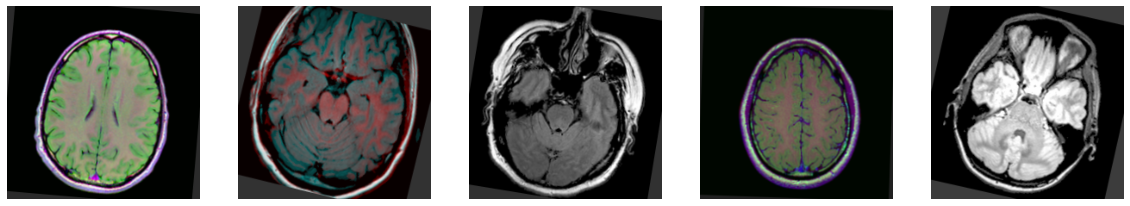

In [6]:
rand_idx = np.random.choice(len(labeled_dataset), 5)
samples = [toimage(labeled_dataset[idx]) for idx in rand_idx]
plot_samples(samples)

### Training

In [7]:
model = UNet(in_channels=3, out_channels=1)
model.to(params.device)
optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
loss_fn = DiceLoss()
metrics = {'dice score': dice_score}

In [8]:
logs_dir = os.path.join(params.model_dir, "logs")
%tensorboard --logdir {logs_dir} --host 0.0.0.0 --port 8812

In [ ]:
train_eval_semi_supervised(model, optimizer, loss_fn, labeled_loader, unlabeled_loader, val_loader, metrics, params)

Epoch 1/100
100%|██████████| 24/24 [00:07<00:00,  3.26it/s, loss=0.978]
- Train metrics: dice score: 0.001 ; labeled loss: 0.992 ; unlabeled loss: 0.000 ; loss: 0.992
- Eval metrics : dice score: 0.099 ; loss: 0.947
Epoch 2/100
100%|██████████| 24/24 [00:06<00:00,  3.72it/s, loss=0.968]
- Train metrics: dice score: 0.094 ; labeled loss: 0.952 ; unlabeled loss: 0.000 ; loss: 0.952
- Eval metrics : dice score: 0.257 ; loss: 0.939
Epoch 3/100
100%|██████████| 24/24 [00:06<00:00,  3.78it/s, loss=0.964]
- Train metrics: dice score: 0.125 ; labeled loss: 0.954 ; unlabeled loss: 0.000 ; loss: 0.954
- Eval metrics : dice score: 0.164 ; loss: 0.939
Epoch 4/100
100%|██████████| 24/24 [00:06<00:00,  3.81it/s, loss=0.962]
- Train metrics: dice score: 0.180 ; labeled loss: 0.966 ; unlabeled loss: 0.000 ; loss: 0.966
- Eval metrics : dice score: 0.318 ; loss: 0.932
Epoch 5/100
100%|██████████| 24/24 [00:06<00:00,  3.81it/s, loss=0.959]
- Train metrics: dice score: 0.498 ; labeled loss: 0.924 ; unlab

### Evaluation

In [ ]:
output_list = generate_outputs(model, val_loader, params, save=True)

In [ ]:
rand_idx = np.random.choice(len(output_list), 5)
samples = [output_list[idx] for idx in rand_idx]
plot_samples(samples)